Cosumnes Model 
@author: Andrew

This notebook ran on 5/10/2021 and couldn't handle the increased number of layers

In [1]:
# standard python utilities
import os
import sys
import glob
import pandas as pd
import numpy as np
import calendar
import time

# standard python plotting utilities
import matplotlib as mpl
import matplotlib.pyplot as plt

# standard geospatial python utilities
import pyproj # for converting proj4string
import shapely
import geopandas as gpd
import rasterio

# mapping utilities
import contextily as ctx
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar
import matplotlib.font_manager as fm

In [2]:

# run installed version of flopy or add local path
try:
    import flopy
    from flopy.discretization.structuredgrid import StructuredGrid
    from flopy.utils.reference import SpatialReference
    from flopy.utils import Raster
except:
    import flopy
    fpth = os.path.abspath(os.path.join('..', '..'))
    sys.path.append(fpth)
    from flopy.discretization.structuredgrid import StructuredGrid
    from flopy.utils.reference import SpatialReference
    from flopy.utils import Raster
from flopy.utils.gridgen import Gridgen
from flopy.utils import OptionBlock
import flopy.utils.binaryfile as bf


print(sys.version)
print('numpy version: {}'.format(np.__version__))
print('matplotlib version: {}'.format(mpl.__version__))
print('flopy version: {}'.format(flopy.__version__))

3.7.11 (default, Jul 27 2021, 09:42:29) [MSC v.1916 64 bit (AMD64)]
numpy version: 1.21.2
matplotlib version: 3.4.3
flopy version: 3.3.4


In [3]:

# Transient -> might want to think about making SP1 steady
end_date = '2019-12-31'
# end_date = '2018-01-02'
strt_date = '2018-01-01'

dates = pd.date_range(strt_date, end_date)

# The number of periods is the number of dates 
nper = len(dates)+1

# Each period has a length of one because the timestep is one day, have the 1st stress period be out of the date range
# need to have the transient packages start on the second stress period
perlen = np.ones(nper)
# Steady or transient periods
steady = np.zeros(nper)
steady[0] = 1 # first period is steady state, rest are transient
steady = steady.astype('bool').tolist()
# Reduce the number of timesteps to decrease run time
nstp = np.ones(nper)*np.append(np.ones(1),6*np.ones(nper-1))

In [4]:
#Maribeth's model parameters, had to switch nrow and ncol due to her issue in xul, yul
nrow=100
ncol=230
delr=200
delc=200
rotation=52.9

# The number of layers should be 1 for the Mehrten formation, 1 for the laguna plus the number of TPROGS layers,
# where the Laguna formation will be clipped by the TPROGS layers
num_tprogs = 120
nlay = 2 + num_tprogs
tprog_thick = 0.5

# There is essentially no difference bewtween WGS84 and NAD83 for UTM Zone 10N
# proj4_str='EPSG:26910'
proj4_str='+proj=utm +zone=10 +ellps=WGS84 +datum=WGS84 +units=m +no_defs '

In [5]:
## Set up directory referencing
# Package data
git_dir = os.path.dirname(os.path.dirname(os.getcwd()))
gwfm_dir = '\\'.join(str.split(git_dir,'\\')[0:3])+ '/Box/research_cosumnes/GWFlowModel'
print(git_dir, gwfm_dir)

C:\Users\andrewc\Documents\GitHub\CosumnesRiverRecharge C:\Users\andrewc/Box/research_cosumnes/GWFlowModel


In [6]:
from flopy.utils.geometry import Polygon, LineString, Point
# Original model domain, 44.7 deg angle
# m_domain = gpd.read_file(gwfm_dir+'\\GWModelDomain_UTM10N\\GWModelDomain_Rec_UTM10N.shp')
# New model domain 52.9 deg
m_domain = gpd.read_file(gwfm_dir+'\\NewModelDomain\\GWModelDomain_52_9deg_UTM10N_WGS84.shp')

# Need to check this when changing model domains
xul, yul = list(m_domain.geometry.values[0].exterior.coords)[1]
list(m_domain.geometry.values[0].exterior.coords)
# m_domain.geometry.values[0].exterior

C:\Users\andrewc\Anaconda3\envs\geosp\lib\site-packages\geopandas\_vectorized.py:142: DeprecationWarning: An exception was ignored while fetching the attribute `__array_interface__` from an object of type 'Polygon'.  With the exception of `AttributeError` NumPy will always raise this exception in the future.  Raise this deprecation warning to see the original exception. (Warning added NumPy 1.21)
  aout[:] = out


[(645500.0, 4227700.0),
 (629548.3214234954, 4239764.159754906),
 (657295.8888597784, 4276453.020480867),
 (673247.567436283, 4264388.860725961),
 (645500.0, 4227700.0)]

According to Flopy GitHub "Technically you need to create both a SpatialReference object and a ModelGrid object, but in practice the code looks very similar and can easily be implemented in one line."
WGS84 Zone 10N has EPSG: 32610  
Lower left corner of model is   
Zone 10 N  
Easting: 661211.18 m E  
Northing: 4249696.50 m N  
angle is approximate 53 degrees  

In [7]:
ext_dir = 'F:/WRDAPP'
c_dir = 'C:/WRDAPP'

if os.path.exists(ext_dir):
    loadpth = ext_dir 
elif os.path.exists(c_dir):
    loadpth = c_dir 

loadpth = loadpth +'/GWFlowModel/Cosumnes/Cosumnes_simple/'
model_ws = loadpth+'WEL_RIV_RCH_tprogs_'+str(nlay)+'layers'


In [8]:
m = flopy.modflow.Modflow(modelname = 'MF', exe_name = 'MODFLOW-NWT.exe', 
                          version = 'mfnwt', model_ws=model_ws)
# m = flopy.modflow.Modflow(modelname = 'MF', exe_name = 'mf2005', 
#                           version = 'mf2005', model_ws='data')
#lenuni = 1 is in ft, lenuni = 2 is in meters
# itmuni is time unit 5 = years, 4=days, 3 =hours, 2=minutes, 1=seconds
dis = flopy.modflow.ModflowDis(nrow=nrow, ncol=ncol, 
                               nlay=nlay, delr=delr, delc=delc,
                               model=m, lenuni = 2, itmuni = 4,
                               xul = xul, yul = yul,rotation=rotation, proj4_str=proj4_str,
                              nper = nper, perlen=perlen, nstp=nstp, steady = steady,
                              start_datetime = strt_date)


In [9]:
# m.modelgrid.set_coord_info(xoff=xoff, yoff=yoff, proj4='EPSG:32610', angrot=angrot)
mg = m.modelgrid
# Write model grid to shapefile for later use
# mg.write_shapefile(gwfm_dir+'/DIS_data/grid/grid.shp', epsg = '32610')
# mg.write_shapefile(gwfm_dir+'/DIS_data/44_7_grid/44_7_grid.shp', epsg = '32610')


In [10]:
# Load model grid as geopandas object
grid_p = gpd.read_file(gwfm_dir+'/DIS_data/grid/grid.shp')
# grid_p = gpd.read_file(gwfm_dir+'/DIS_data/44_7_grid/44_7_grid.shp')
# print(gwfm_dir)

# Find Michigan Bar location
# mb_gpd = sensors[sensors.Sensor_id == "MI_Bar"]
# mb_grid = gpd.sjoin(mb_gpd, grid_p, how = 'left', op = 'intersects')

C:\Users\andrewc\Anaconda3\envs\geosp\lib\site-packages\geopandas\_vectorized.py:142: DeprecationWarning: An exception was ignored while fetching the attribute `__array_interface__` from an object of type 'Polygon'.  With the exception of `AttributeError` NumPy will always raise this exception in the future.  Raise this deprecation warning to see the original exception. (Warning added NumPy 1.21)
  aout[:] = out
C:\Users\andrewc\Anaconda3\envs\geosp\lib\site-packages\geopandas\_vectorized.py:142: DeprecationWarning: An exception was ignored while fetching the attribute `__array_interface__` from an object of type 'Polygon'.  With the exception of `AttributeError` NumPy will always raise this exception in the future.  Raise this deprecation warning to see the original exception. (Warning added NumPy 1.21)
  aout[:] = out
C:\Users\andrewc\Anaconda3\envs\geosp\lib\site-packages\geopandas\_vectorized.py:142: DeprecationWarning: An exception was ignored while fetching the attribute `__array

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [11]:
# Get vertexes of model domain
# ll = mg.get_coords(0, 0) #lower left
# lr = mg.get_coords(nrow*delr, 0) #lower right
# ur = mg.get_coords(nrow*delr, ncol*delc) #upper right
# ul = mg.get_coords(0, ncol*delc) #upper left
ll = mg.get_coords(0, 0) #lower left
lr = mg.get_coords(0, nrow*delr) #lower right
ur = mg.get_coords(ncol*delc, nrow*delr) #upper right
ul = mg.get_coords(ncol*delc, 0) #upper left
print(ll, lr, ur, ul)

# Shapefile of model bounds
from shapely.geometry import Polygon
vertices = np.stack(np.asarray((ll,lr, ur, ul)))
vertices
geoms = Polygon(vertices)

(645500.0, 4227700.0) (629548.3214234954, 4239764.159754906) (657295.8888597784, 4276453.020480867) (673247.567436283, 4264388.860725961)


### Raster files can be loaded using the `Raster.load` method

In [12]:
# Full size dem of northern sac valley
# raster_name = gwfm_dir+"/DEM_data/USGS_ten_meter_dem/transformed.tif"

# rio10_utm = Raster.load(raster_name)

In [13]:
# rio10_utm.plot()
# t0 = time.time()
# rio10_utm.crop(vertices, invert=False)
# crop_time = time.time() - t0
# rio10_utm.plot()


In [14]:
# Nearest neighbor determines the nearest pixel and assumes its value
# linear is as it sounds, cubic is the smoothed version of linear essentially by using a cubic function
# the linear method takes a very, very long time - an hour plus??, just stick with nearest
# nearest takes 170.209 seconds - 220 seconds
# the linear interpolation causes the program to crash
# t0 = time.time()
# dem_data = rio10_utm.resample_to_grid(m.modelgrid.xcellcenters,
#                                 m.modelgrid.ycellcenters,
#                                 band=rio10_utm.bands[0],
#                                 method="nearest")
# resample_time = time.time() - t0
# print("Resample time, nearest neighbor: {:.3f} sec".format(time.time() - t0))

<>:5: DeprecationWarning: invalid escape sequence \D
<>:5: DeprecationWarning: invalid escape sequence \D
<>:5: DeprecationWarning: invalid escape sequence \D
C:\Users\andrewc\AppData\Local\Temp/ipykernel_20316/2084741058.py:5: DeprecationWarning: invalid escape sequence \D
  dem_data = np.loadtxt(gwfm_dir+'\DIS_data\dem_52_9_200m_linear.tsv', delimiter = '\t')


<AxesSubplot:>

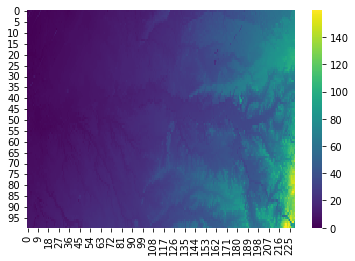

In [15]:
# np.savetxt(gwfm_dir+'\DIS_data\dem_44_7_200m_nearest.tsv', dem_data, delimiter = '\t')

# Based on Maribeth's grid aligned with Alisha's TPROGS model
# dem_data = np.loadtxt(gwfm_dir+'\DIS_data\dem_52_9_200m_nearest.tsv', delimiter = '\t')
dem_data = np.loadtxt(gwfm_dir+'\DIS_data\dem_52_9_200m_linear.tsv', delimiter = '\t')
# dem_data = np.loadtxt(gwfm_dir+'\DIS_data\dem_44_7_200m_linear_missing_right_corner.tsv', delimiter = '\t')

# dem_data = np.loadtxt(gwfm_dir+'\DIS_data\dem_44_7_200m_nearest.tsv', delimiter = '\t')

import seaborn as sns
sns.heatmap(dem_data, cmap = 'viridis', vmin = 0)

# Capture cross section of deeper geology

In [16]:
# Pre-cretaceous metamorphic rocks - (variable thickness 200-500 ft thick)
# Ione formation (200 ft thick)
# Valley Springs formation (300 ft thick)
# Mehrten Formation (100 ft thick to 300 ft thick) (1-2 deg dip)
# Laguna Formation (less than 100 ft to between 200-300 ft thick) (less than 1 deg dip)
# upper formation (informed by well logs) (100 ft)
# ibound < 0 is constant head
# ibound = 0 is inactive cell
# ibound > 0 is active cell

## Need to adjust for change in model grid, based on Michigan Bar previously, maybe also look at effect of model domain angle vs cross section angle

In [17]:

# The stream gage at michigan bar is now 13 columns in from the boundary
# mehrtenbound

# Cross section E appears to have an angle of 0 compared to the model domain,

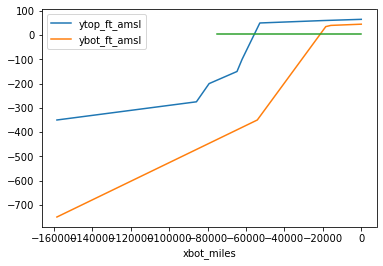

In [18]:
# # columns are xtop_miles, ytop_ft_amsl, xbot_miles, ytop_ft_amsl
# # XS upper bound should be at Michigan bar which is between Jackson road and Sacramento-Amador county line split
# # Mile 36 is approximately where Michigan bar aligns with the cross section
MB_XS_mile = 36
mehrtenbound = pd.read_csv(gwfm_dir+'/DIS_data/Mehrten_boundary_x_y.csv', parse_dates = False, 
                index_col = False, sep = ',', header = 'infer')
# Convert miles to feet and sets x value based on location of Michigan bar
# 0 is michigan bar and each major change in geologic dip is based on distance from Michigan Bar
mehrtenbound.xtop_miles = -5280*(MB_XS_mile - mehrtenbound.xtop_miles)
mehrtenbound.xbot_miles = -5280*(MB_XS_mile - mehrtenbound.xbot_miles)
# No flod boundary based on the original coordinates of the bottom of the Mehrten formation
mehrtenbound.noflow_x_miles = -5280*(MB_XS_mile - mehrtenbound.noflow_x_miles)

# East of mile 32 the entire vertical cross section, including up to the near entire surface
# is composed of old geologic formations that are not water bearing
volcanic_bound = (MB_XS_mile - 32)*-5280
# noflow_ind = int((1-(volcanic_bound/sumx))*ncol)

# Plot the x and y values
fig, ax = plt.subplots(1, 1)
mehrtenbound.plot(x = 'xtop_miles', y = 'ytop_ft_amsl', ax = ax)
mehrtenbound.plot(x = 'xbot_miles', y = 'ybot_ft_amsl', ax = ax)
plt.plot(-100*3.28*np.arange(0,len(dis.top[40,:])), np.flip(3.28*dis.top[40,:]))
# print(mehrtenbound)

In [19]:

def xy_to_botm(xbound_ft, ybound_ft, nspace,ntransversespace):
    laybotm = np.zeros((ntransversespace, nspace))
    # Nspace will be either nrow or ncol depending model direction
    # ntransversespace is the opposite of nspace (ie nrow if nspace is ncol)
    # Calculate the distance between each major change in dip
    dx = np.diff(xbound_ft)
    # Scale by the total distance across the coordinates to get percentages
    sumx = np.sum(dx)
    dx /= sumx
    # Multiply the number of columns by the percent of columns in each section of constant dip
    dx *= nspace
    # Round the number of columns to allow proper use for indexing
    nx = np.round(dx).astype(int)
    # Fix any discrepancy in number of columns due to issues with rouding the percentages of columns
    # Add a column to the last set of columns because there is already uncertainty at the deeper end
    while(np.sum(nx)-nspace !=0):
        if np.sum(nx)-nspace <0:
            nx[-1] += 1
        elif np.sum(nx)-nspace >0:
            nx[-1] -= 1
    sum(nx)

    # Now split the coordinates into downsized coordinates in between each major change in dip
    k = 0
    for i in np.arange(0,len(nx)):
        for j in np.arange(0,ntransversespace):
            laybotm[j, k:k+nx[i]] = np.arange(ybound_ft[i],ybound_ft[i+1], -(ybound_ft[i]-ybound_ft[i+1])/nx[i])
        k += nx[i]
    return(laybotm)

In [20]:
# X (east -west) and y (up-down vertical) of major dip changes for Mehrten Formation top boundary

mehrten_top = xy_to_botm(mehrtenbound.xtop_miles,mehrtenbound.ytop_ft_amsl, ncol, nrow)
# X (east -west) and y (up-down vertical) of major dip changes for Mehrten Formation bottom boundary
# drop na is because there are less values to mark changes in the bottom than top boundary
mehrten_bottom = xy_to_botm(mehrtenbound.xbot_miles.dropna(),mehrtenbound.ybot_ft_amsl.dropna(), ncol, nrow)

# Original x,y data for Mehrten bottom boundary to represent the noflow bounds
no_flow_bound = xy_to_botm(mehrtenbound.noflow_x_miles.dropna(), mehrtenbound.noflow_y_ft_amsl.dropna(),ncol,nrow)

In [21]:
botm = np.zeros((nlay, nrow, ncol))
# Convert units from ft to meters and flip to match direction
botm[-2,:,:] = np.flip(mehrten_top/3.28)
botm[-1,:,:] = np.flip(mehrten_bottom/3.28)
no_flow_bound = np.flip(no_flow_bound/3.28)
dis.botm = botm
# dis.plot()

In [22]:
botm.shape, dem_data.shape

((122, 100, 230), (100, 230))

In [23]:
num_tprogs, nlay

(120, 122)

## Adjustment to bottom boundary to ensure sufficient top layer thickness for the TPROGS model
Although the bottom boundaries are being artifically lowered to allow for sufficient layer thickness, this will be corrected when ibound is implemented based on where the actual bottom boundary is and where there is high elevations based on likelihood to be volcanics geology.

In [24]:
# The TPROGS model is 100m thick with some of it above the land surface
# to be safe, there should be at least 50 meters below ground surface to the bottom boundary

# Create TPROGS layers from bottom up
# tprog_thick = 100/num_tprogs
# botm[-3,:,:] = -80
# for i in np.arange(-4,-3-num_tprogs,-1):
#     botm[i,:,:] = botm[i+1,:,:] + tprog_thick
    
    
# Create TPROGS layers from top down
# tprog_thick = 100/num_tprogs
# botm[0,:,:] = dem_data - tprog_thick
botm[0,:,:] = -10
for i in np.arange(1,num_tprogs):
    botm[i,:,:] = botm[i-1,:,:] -tprog_thick
    
# Thickness to give to bottom layers below the TPROGS layers just to provide adequate spacing,
# this will be corrected by changing the geology in the layers above to account for what is actually in
# the Mehrten and what is in the Laguna formations, thickness of 5 also prevents any messy overlap
thickness_to_skip =10
# # Find where top boundary of Mehrten Formation rises within 10 meters of the top layer (10m for sufficient layer thickness)
bot3ind = np.min(np.where(botm[-2,:,:]>botm[-3,:,:]- thickness_to_skip)[1])

# # Where the top boundary of Mehrten was within 10 meters of the top layer 
# # set it equal to top layer elevation minus 10 for sufficient layer thickness
botm[-2,:,bot3ind:] = botm[-3,0,bot3ind]- thickness_to_skip
# # Repeat steps above for bottom of Mehrten formation with the top of the Mehrten formation
bot3ind = np.min(np.where(botm[-1,0,:]>botm[-2,0,:]- thickness_to_skip))
botm[-1,:,bot3ind:] = botm[-2,0,bot3ind]-thickness_to_skip

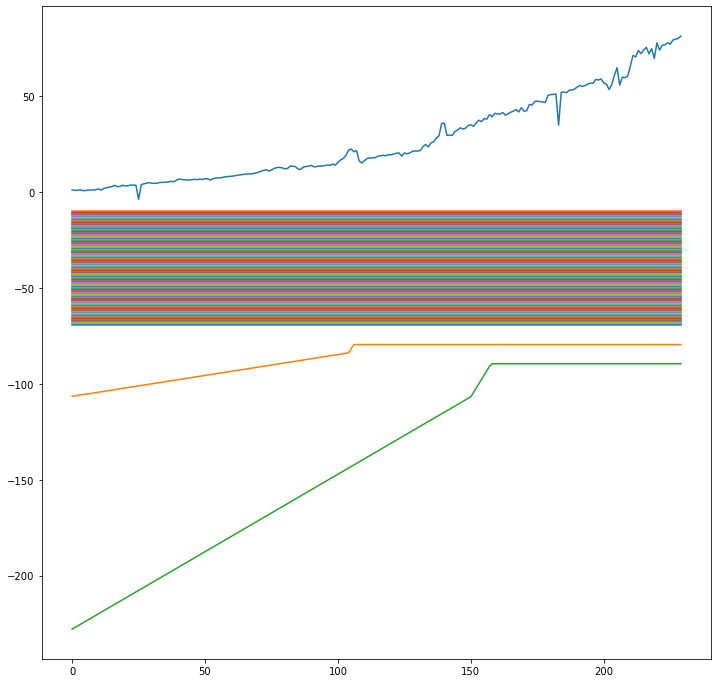

In [25]:

fig,ax = plt.subplots(figsize = (12,12))
plt.plot(dem_data[8,:])

for i in np.arange(0,nlay):
    plt.plot(botm[i,8,:])

In [26]:
# Set the elevation of the top layer based on the DEM
m.dis.top = dem_data
# Bottom of model based on geology
m.dis.botm = botm
chk = dis.check()
chk.summary_array


DIS PACKAGE DATA VALIDATION:
  2737000 Errors:
    2737000 instances of thin cells (less than checker threshold of 1.0)

  Checks that passed:
    zero or negative thickness
    nan values in top array
    nan values in bottom array



rec.array([('Error', 'DIS',   1,  0,   0, 0.5, 'thin cells (less than checker threshold of 1.0)'),
           ('Error', 'DIS',   1,  0,   1, 0.5, 'thin cells (less than checker threshold of 1.0)'),
           ('Error', 'DIS',   1,  0,   2, 0.5, 'thin cells (less than checker threshold of 1.0)'),
           ...,
           ('Error', 'DIS', 119, 99, 227, 0.5, 'thin cells (less than checker threshold of 1.0)'),
           ('Error', 'DIS', 119, 99, 228, 0.5, 'thin cells (less than checker threshold of 1.0)'),
           ('Error', 'DIS', 119, 99, 229, 0.5, 'thin cells (less than checker threshold of 1.0)')],
          dtype=[('type', 'O'), ('package', 'O'), ('k', '<i4'), ('i', '<i4'), ('j', '<i4'), ('value', '<f8'), ('desc', 'O')])

## Import soil data for Lake Package, UZF Package, SFR Package hydraulic parameters

In [27]:
mb_name = gwfm_dir+"/NewModelDomain/GWModelDomain_52_9deg_UTM10N_WGS84.shp"

mb = gpd.read_file(mb_name)
mb = mb.to_crs('epsg:32610')

C:\Users\andrewc\Anaconda3\envs\geosp\lib\site-packages\geopandas\_vectorized.py:142: DeprecationWarning: An exception was ignored while fetching the attribute `__array_interface__` from an object of type 'Polygon'.  With the exception of `AttributeError` NumPy will always raise this exception in the future.  Raise this deprecation warning to see the original exception. (Warning added NumPy 1.21)
  aout[:] = out


In [28]:
uzf_path = gwfm_dir+'\\UZF_data'
soil_path = uzf_path+'\\wss_gsmsoil_CA'
# # Read in the soil map spatial data
# soil_gpd = gpd.read_file(uzf_path+'\\wss_gsmsoil_CA\\spatial\\gsmsoilmu_a_ca.shp')
# soil_gpd = soil_gpd.to_crs('EPSG:32610')
# # soil_gpd.plot()

### Write grid_uzf to shapefile to avoid having to repeat analysis

In [29]:
# grid_uzf.to_file(uzf_path+'/final_grid_uzf/griduzf.shp')
# grid_uzf = gpd.read_file(uzf_path+'/final_grid_uzf/griduzf.shp')

In [30]:
# def fill_uzf(uzfvalues, grid_uzf):
#     # convert geopandas object to regular np array for soil data
#     temp = np.zeros((nrow,ncol))
#     temp[(grid_uzf.row.values-1).astype(int),(grid_uzf.column.values-1).astype(int)] = uzfvalues
#     return(temp)

In [31]:
soilKs_array = np.loadtxt(uzf_path+'/final_soilKs.tsv', delimiter = '\t')
soiln_array = np.loadtxt(uzf_path+'/final_soiln.tsv', delimiter = '\t')
soileps_array = np.loadtxt(uzf_path+'/final_soileps.tsv', delimiter = '\t')

# soilKs_array = fill_uzf(grid_uzf.Ksat_Rep, grid_uzf)
# soiln_array = fill_uzf(grid_uzf.Porosity_R, grid_uzf)
# soileps_array = fill_uzf(grid_uzf.EPS, grid_uzf)

# np.savetxt(uzf_path+'/final_soilKs.tsv', soilKs_array, delimiter = '\t')
# np.savetxt(uzf_path+'/final_soiln.tsv', soiln_array, delimiter = '\t')
# np.savetxt(uzf_path+'/final_soileps.tsv', soileps_array, delimiter = '\t')

# RIV

In [32]:
sfr_dir = gwfm_dir+'/SFR_data/'

In [33]:
# grid_sfr.to_file(sfr_dir+'/final_grid_sfr/grid_sfr.shp')
grid_sfr = gpd.read_file(sfr_dir+'/final_grid_sfr/grid_sfr.shp')
sfr_dir

C:\Users\andrewc\Anaconda3\envs\geosp\lib\site-packages\geopandas\_vectorized.py:142: DeprecationWarning: An exception was ignored while fetching the attribute `__array_interface__` from an object of type 'Polygon'.  With the exception of `AttributeError` NumPy will always raise this exception in the future.  Raise this deprecation warning to see the original exception. (Warning added NumPy 1.21)
  aout[:] = out
C:\Users\andrewc\Anaconda3\envs\geosp\lib\site-packages\geopandas\_vectorized.py:142: DeprecationWarning: An exception was ignored while fetching the attribute `__array_interface__` from an object of type 'Polygon'.  With the exception of `AttributeError` NumPy will always raise this exception in the future.  Raise this deprecation warning to see the original exception. (Warning added NumPy 1.21)
  aout[:] = out
C:\Users\andrewc\Anaconda3\envs\geosp\lib\site-packages\geopandas\_vectorized.py:142: DeprecationWarning: An exception was ignored while fetching the attribute `__array

'C:\\Users\\andrewc/Box/research_cosumnes/GWFlowModel/SFR_data/'

In [34]:
# floodplain sensor info
fp_sensors = gpd.read_file(gwfm_dir+"/LAK_data/floodplain_logger_metadata.csv", header = True)
fp_sensors.Northing = fp_sensors.Northing.astype(np.float64)
fp_sensors.Easting = fp_sensors.Easting.astype(np.float64)
fp_sensors.geometry = gpd.points_from_xy(fp_sensors.Easting, fp_sensors.Northing)
fp_sensors.crs = 'epsg:32610'

In [35]:
# od_breach is the sensor location where the breach was made in the levees for flow to leave the river
od_breach = fp_sensors[fp_sensors['Logger Location']=='OD_Excavation']
od_breach


,Logger Location,Logger Type,Easting,Northing,Elevation,Solinst Logger Serial Number 2012,Solinst Logger Serial Number 2013,Solinst Logger Serial Number 2014,Solinst Logger Serial Number 2015,Solinst Logger Serial Number 2016,geometry
2,OD_Excavation,Breach,641763.495,4241361.24,6.597,,,,32037867,21052169,POINT (641763.495 4241361.240)


In [36]:
# # Buffer the location of the breach sensor to have overlap with the river streamline
# just sjoin the geometry because the extra info is unnecessary
# spatial join breach sensor polygon with sfr grid locations to find match
grid_breach = gpd.sjoin(grid_sfr, 
                        gpd.GeoDataFrame(geometry = od_breach.geometry.buffer(25), crs = 'epsg:32610'), how = "inner", op= "intersects")
# add a reach to the overlap cell that will be used to divert flow (there will be two reaches in one cell)
grid_breach

C:\Users\andrewc\Anaconda3\envs\geosp\lib\site-packages\geopandas\_vectorized.py:790: DeprecationWarning: An exception was ignored while fetching the attribute `__array_interface__` from an object of type 'Polygon'.  With the exception of `AttributeError` NumPy will always raise this exception in the future.  Raise this deprecation warning to see the original exception. (Warning added NumPy 1.21)
  for geom in data
C:\Users\andrewc\Anaconda3\envs\geosp\lib\site-packages\geopandas\_vectorized.py:142: DeprecationWarning: An exception was ignored while fetching the attribute `__array_interface__` from an object of type 'Polygon'.  With the exception of `AttributeError` NumPy will always raise this exception in the future.  Raise this deprecation warning to see the original exception. (Warning added NumPy 1.21)
  aout[:] = out


,node,row,column,index_righ,z,easting,northing,slope,Point_orde,length_m,reach,geometry,index_right
209,10164,45.0,44.0,4994.0,6.838629,641880.440454,4.241351e+06,0.0003,4994.0,210,210,"POLYGON ((641754.648 4241315.151, 641875.290 4...",2


In [37]:
XS8pt = pd.read_csv(sfr_dir+'8pointXS.csv')
XSlocs = gpd.read_file(sfr_dir+'8pointXS_locs\\8pointXS_locs.shp')
XSlocs.crs = 32610

XSg  = gpd.sjoin(grid_sfr, XSlocs, how = "inner", op= "contains", lsuffix = 'sfr',rsuffix = 'xs')
# Append the grid_breach location to the list of cross sections to split the segment
XSg = XSg.append(grid_breach).sort_values('reach')
# Copy the XS site name from the previous last site to the breach site to keep same XS
XSg.Site.iloc[-1] = XSg.Site.iloc[-2]
len(XSg), len(XS8pt.loc[0,:])/2

C:\Users\andrewc\Anaconda3\envs\geosp\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


(27, 30.0)

### Read in 8 pt XS, revised by simplifying from Constantine 2001

In [38]:
xs_sfr = grid_sfr.set_index('reach')
# set all reaches to start as segment 1 which will be changed iteratively based on the number of cross-sections
xs_sfr['iseg'] = 1
# add a column reach_new that will be changed iteratively as the segment number is changed
xs_sfr['reach_new'] = xs_sfr.index
# xs_sfr

## Define reach data based on ISFROPT

In [39]:
## Given the reach number of each XS, the 718 reaches will be broken down into each segment
## create a new reach column based on XS reach number and 

segcount = 2
for i in np.arange(0,len(XSg)):
    temp_reach = XSg.reach.values[i]
    rchnum = xs_sfr.index[-1] - temp_reach+1
    xs_sfr.reach_new.loc[temp_reach:] = np.linspace(1,rchnum, rchnum)
    xs_sfr.iseg.loc[temp_reach:] = segcount
    segcount +=1

In [40]:
xs_sfr.reach_new = xs_sfr.reach_new.astype(int)


In [41]:
grid_sfr.row = (grid_sfr.row.values-1).astype(int)
grid_sfr.column = (grid_sfr.column.values-1).astype(int)

In [42]:
# Determine which layer the streamcell is in
# since the if statement only checks whether the first layer is greater than the streambed elevation, 
# otherwise it would be less than and zero (most should be in layer 0)
sfr_lay = np.zeros(len(grid_sfr))

for i in np.arange(0,nlay-1):
    # pull out elevation of layer bottom
    lay_elev = botm[i, grid_sfr.row.values, grid_sfr.column.values]
    for j in np.arange(0,len(grid_sfr)):
        # want to compare if streambed is lower than the layer bottom
        # 1 will be subtracted from each z value to make sure it is lower than the model top in the upper reaches
        if lay_elev[j] < (grid_sfr.z.values-1)[j]:
            sfr_lay[j] = i 
        


In [43]:
xs_sfr

,node,row,column,index_righ,z,easting,northing,slope,Point_orde,length_m,geometry,iseg,reach_new
reach,,,,,,,,,,,,,
1,21609,94.0,219.0,280.0,52.796051,670841.187393,4.263264e+06,0.0020,280.0,130,"POLYGON ((670683.251 4263319.151, 670803.892 4...",1,1
2,21608,94.0,218.0,298.5,52.426051,670668.236881,4.263210e+06,0.0020,298.5,240,"POLYGON ((670562.609 4263159.634, 670683.251 4...",1,2
3,21377,93.0,217.0,324.5,51.906051,670442.468974,4.263109e+06,0.0020,324.5,200,"POLYGON ((670282.451 4263120.759, 670403.092 4...",1,3
4,21376,93.0,216.0,345.0,51.496051,670274.742955,4.263004e+06,0.0020,345.0,210,"POLYGON ((670161.809 4262961.242, 670282.451 4...",1,4
5,21375,93.0,215.0,361.0,51.176051,670157.742069,4.262904e+06,0.0020,361.0,110,"POLYGON ((670041.168 4262801.725, 670161.809 4...",1,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...
252,10358,46.0,8.0,5968.0,0.624646,637733.164364,4.235512e+06,0.0003,5968.0,230,"POLYGON ((637571.068 4235451.906, 637691.710 4...",28,43
253,10128,45.0,8.0,5988.5,0.563146,637534.930980,4.235523e+06,0.0003,5988.5,180,"POLYGON ((637411.551 4235572.547, 637532.192 4...",28,44
254,9897,44.0,7.0,6014.5,0.485146,637283.184475,4.235568e+06,0.0003,6014.5,240,"POLYGON ((637131.393 4235533.672, 637252.034 4...",28,45


In [44]:
# need to convert from meters/day to meters/month
vertk = soilKs_array[grid_sfr.row, grid_sfr.column]*30
strbd_thick = 1.5

In [45]:
# find average stream width
xswidth = XS8pt.iloc[:,np.arange(0,XS8pt.shape[1],2)]
widths = xswidth.iloc[-1,:] - xswidth.iloc[0,:]
avgwidth = np.mean(xswidth.iloc[-1,:] - xswidth.iloc[0,:])

In [46]:
# lay, row, col, stage, cond, rbot
grid_sfr
cond = grid_sfr.length_m*avgwidth*vertk/strbd_thick
# riv_spd = np.append(sfr_lay, [grid_sfr.row.values,grid_sfr.column.values,
#           grid_sfr.z.values, cond,grid_sfr.z.values-1.5],axis=1)

In [47]:
riv_spd = np.transpose(np.vstack([sfr_lay,grid_sfr.row.values,grid_sfr.column.values,
          grid_sfr.z.values, cond,grid_sfr.z.values-1.5]))

In [48]:
riv_dict = {0:riv_spd}
riv_dict

{0: array([[ 1.20000000e+02,  9.30000000e+01,  2.18000000e+02,
          5.27960513e+01,  1.27079416e+05,  5.12960513e+01],
        [ 1.20000000e+02,  9.30000000e+01,  2.17000000e+02,
          5.24260513e+01,  2.34608153e+05,  5.09260513e+01],
        [ 1.20000000e+02,  9.20000000e+01,  2.16000000e+02,
          5.19060513e+01,  1.95506794e+05,  5.04060513e+01],
        ...,
        [ 1.20000000e+02,  4.30000000e+01,  6.00000000e+00,
          4.85145897e-01,  2.95810709e+05, -1.01485410e+00],
        [ 1.20000000e+02,  4.20000000e+01,  5.00000000e+00,
          3.93645897e-01,  2.83485263e+05, -1.10635410e+00],
        [ 1.20000000e+02,  4.10000000e+01,  4.00000000e+00,
          3.09645897e-01,  2.83485263e+05, -1.19035410e+00]])}

In [49]:
riv = flopy.modflow.ModflowRiv(model = m, stress_period_data=riv_dict)

## Complex ibound

### Define no flow cells based on elevation, informed by DWR cross sections and geologic maps of volcanic geology fingers leaving the mountains
In general, the location of Michigan Bar is near the boundary where there is total volcanics to majority alluvium. However there is a major finger North and South of the Cosumnes River of andesititc conglomerate, sandstone, breccia

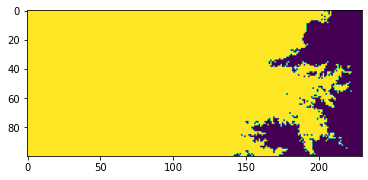

In [50]:
# Simplified ibound, only no flow cell if it is below the bottom of the Mehrten Formation
# Specify no flow boundary based on rough approx of geology (upper basin volcanics)
ibound = np.ones([nlay, nrow,ncol])
strt = np.ones((nlay, nrow, ncol), dtype = np.float32)
# The model should start in hydraulic connection
strt[:,:,:] = np.mean(m.dis.top[:,:], axis = 0)

cutoff_elev = 56
ibound = ibound*(dem_data<cutoff_elev)

plt.imshow(ibound[0,:,:])

### Create a line bounding the noflow region to set the specified head boundary

In [51]:
import pprint
from rasterio.features import shapes, rasterize

# The function shapes from rasterio requires uint8 format
ibound_line = ibound.astype(rasterio.uint8)
out = shapes(ibound_line,connectivity = 8)
alldata = list(out)

# maxl = 0
maxl = np.zeros(len(alldata))
for i in np.arange(0,len(alldata)):
    maxl[i] = len(alldata[i][0].get('coordinates')[0])
#     if len(alldata[i][0].get('coordinates')[0])>maxl:
#         maxl = len(alldata[i][0].get('coordinates')[0])
#         ind = i
# select the two longest linestring indexes (1st will be chunk down of divide (lower elevation) 2nd will chunk above (high elev))
maxl1, maxl2 = np.where(maxl>np.mean(maxl))[0]
print(maxl[maxl>np.mean(maxl)])

[647. 607.]


In [52]:
temp = alldata[maxl2][0].get('coordinates')[0]
tl = LineString(temp)
tl

In [53]:
from shapely.ops import LineString, linemerge, polygonize, unary_union
tl = LineString(temp)

# Get the constant head or general head boundary after the no flow cells
linerast = rasterio.features.rasterize([tl], out_shape = np.array((nrow,ncol)))
# remove far east bound line
linerast[:,ncol-1] = 0
fix_bound = np.min(np.argwhere(linerast[0,:]==1))
linerast[0,:] = 0
linerast[0,fix_bound]
np.shape(linerast)

# ibound[0,linerast==1] = -1

(100, 230)

In [54]:
from shapely.ops import LineString, linemerge, polygonize, unary_union
tl = LineString(temp)
tu = unary_union(tl)
poly = list(polygonize(tu))
# Set the polygon/raster for the top layer, no buffer needed
poly0 = poly[0].buffer(distance = 0)
polyrast0 = rasterio.features.rasterize([poly0], out_shape = np.array((nrow,ncol)))
# Set the polygon/raster for the top layer, slight buffer needed to expand geologic formation outward with depth as 
# naturally occurs
poly1 = poly[0].buffer(distance = 13)
polyrast1 = rasterio.features.rasterize([poly1], out_shape = np.array((nrow,ncol)))
# Set the polygon/raster for the bottom layer, largest buffer needed
poly2 = poly[0].buffer(distance = 17)
polyrast2 = rasterio.features.rasterize([poly2], out_shape = np.array((nrow,ncol)))

ibound = np.ones([nlay, nrow,ncol])
# Need to decide whether all layers or just the top layer are affected by ibound from elevation
# it is better to define the top layer with a simple dem>elevation check than the rasterize functins that isn't perfect
# ibound[0,polyrast0==1] = 0
# Need to decide whether all layers or just the top layer are affected by ibound from elevation
ibound[-2,polyrast1==1] = 0
# Need to decide whether all layers or just the top layer are affected by ibound from elevation
ibound[-1,polyrast2==1] = 0

# The bottom boundary has a dip of 1-2 degrees which is essentially a slope of 0.015 based on given cross section data
# The layer thickness for TPROGS
laythk = tprog_thick
# It appeared shapely buffer is on the scale of kilometers
run = (laythk/0.015)/1000
run_const = run
for i in np.arange(1,nlay-2):
    # error saying poly[i] is not subscriptable
    polyi = poly[0].buffer(distance = run)
    polyrast = rasterio.features.rasterize([polyi], out_shape = np.array((nrow,ncol)))
    # Need to decide whether all layers or just the top layer are affected by ibound from elevation
    ibound[i,polyrast==1] = 0
    run += run_const

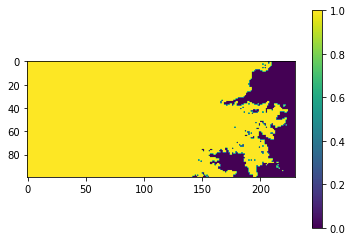

In [55]:
# wherever the constant head/specified head bound is the cells need to be active
ibound[0,dem_data>cutoff_elev] = 0
ibound[0,linerast==1] = 1
plt.imshow(ibound[0,:,:])
plt.colorbar()

In [56]:
# copy the ibound array to alter the geology array to set these cells as low permeability formations
# either marine or volcanic based
deep_geology = ibound[:,:,:]

# reset ibound to all active cells to reduce non-linearity
# still need to take account of no flow cells for lake package
ibound = np.ones([nlay, nrow,ncol])

### Remove no flow cells in the first layer where there are stream cells

In [57]:
# Get indices of SFR cells
sfr_x = grid_sfr.row.values.astype(int)
sfr_y = grid_sfr.column.values.astype(int)
sfr_z = sfr_lay.astype(int)
# Check where SFR cells overlap the no flow cell array 
overlap = ibound[sfr_z, sfr_x, sfr_y]==0
# Convert the cells that overlap from inactive to active cells
ibound[sfr_z[overlap],sfr_x[overlap], sfr_y[overlap]] = 1
# Check where SFR cells overlap the constant head cell array 
overlap = ibound[sfr_z, sfr_x, sfr_y]==-1
# Convert the cells that overlap from inactive to active cells
ibound[sfr_z[overlap],sfr_x[overlap], sfr_y[overlap]] = 1

In [58]:
# where the specified head boundary is the cells must be active
# ibound[0,chd_locs[0], chd_locs[1]] = -1

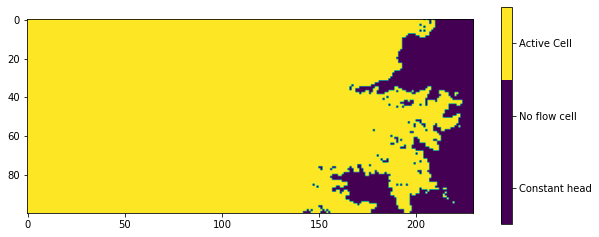

In [59]:
fig, ax = plt.subplots(figsize = (10,10))
# plt.imshow(ibound[0,:,:])
plt.imshow(deep_geology[0,:,:])

cbar = plt.colorbar(shrink = 0.4, ticks = np.arange(-1,2), values = np.arange(-1,2), spacing = 'proportional' )
cbar.ax.set_yticklabels(np.array(('Constant head', 'No flow cell', 'Active Cell'), dtype = 'object' ))
plt.savefig('Plots/Ibound_plot.png', dpi = 300)

In [60]:
# Basic package, BAS

# ibound < 0 is constant head
# ibound = 0 is inactive cell
# ibound > 0 is active cell
# strt is array of starting heads
bas = flopy.modflow.ModflowBas(model = m, ibound=ibound, strt = strt)

In [61]:
bas.check()



BAS6 PACKAGE DATA VALIDATION:
  No errors or warnings encountered.

  Checks that passed:
    isolated cells in ibound array
    Not a number



"When subsurface recharge (MBR2) is negligible,
stream runoff at the mountain front (runoff measured at
point B in Figure 1, or RO) may be considered the total
contribution to MFR [Anderholm, 2000]." (Wilson and Guan 2004)

## General head boundary representing Delta/Sea Level

In [62]:
ghb = flopy.modflow.ModflowGhb(model = m)

## Northwest and Southeast GHB boundaries based on historical WSEL

In [63]:
# raster cropping will be done in outside script so the only part read in will be the final array
ghb_dir = gwfm_dir+'/GHB_data'

In [64]:
strtyear = 2013
endyear = 2019
kriged_fall = np.zeros((int(endyear-strtyear),nrow,ncol))
kriged_spring = np.zeros((int(endyear-strtyear),nrow,ncol))

kriged_NW = np.zeros((int(endyear-strtyear)*2,ncol))
kriged_SE = np.zeros((int(endyear-strtyear)*2,ncol))
# keep track of which place in array matches to year
year_to_int = np.zeros((endyear-strtyear,2))

t=0
for year in np.arange(strtyear,endyear):
    
    # load and place spring kriged data in np array, load spring first
    filename = glob.glob(ghb_dir+'/final_WSEL_arrays/spring'+str(year)+'_kriged_WSEL.tsv')[0]
    df_grid = np.loadtxt(filename)
    kriged_spring[t,:,:] = df_grid
    
    # load and place fall kriged data in np array
    filename = glob.glob(ghb_dir+'/final_WSEL_arrays/fall'+str(year)+'_kriged_WSEL.tsv')[0]
    df_grid = np.loadtxt(filename)
    kriged_fall[t,:,:] = df_grid

    
    # save NW  dataframe
    kriged_NW[t] = kriged_spring[t,0,:]
    kriged_NW[2*t] = kriged_fall[t,0,:]
    # save SE data frame
    kriged_SE[t] = kriged_spring[t,nrow-1,:]
    kriged_SE[2*t] = kriged_fall[t,nrow-1,:]
    
    year_to_int[t,0] = t
    year_to_int[t,1] = year
    t+=1
    

In [65]:
y_num=0

nwhead_fall = kriged_fall[:,0,:]
sehead_fall = kriged_fall[:,-1,:]


# Set kriged water table elevations that are above land surface to land surface
nwhead_fall = np.where(nwhead_fall>dem_data[0,:], dem_data[0,:], nwhead_fall)
sehead_fall = np.where(sehead_fall>dem_data[-1,:], dem_data[-1,:], sehead_fall)

kriged_NW = np.where(kriged_NW>dem_data[0,:], dem_data[0,:], kriged_NW)
kriged_SE = np.where(kriged_SE>dem_data[-1,:], dem_data[-1,:], kriged_SE)

# calculate the average depth to water table for the spring and from 2013-2018 for the northwest and southeast boundary
avg_nw = np.nanmean(kriged_NW,axis=0)
avg_se = np.nanmean(kriged_SE,axis=0)

In [66]:
# steady state GHB layering
nw_lay = np.zeros(ncol)
se_lay = np.zeros(ncol)
for k in np.arange(0,nlay-1):
        # pull out elevation of layer bottom
        lay_elevnw = botm[k, 0, :]
        lay_elevse = botm[k, -1, :]
        for j in np.arange(0,ncol):
            if lay_elevnw[j] > avg_nw[j]:
                nw_lay[j] = k+1
            if lay_elevse[j] > avg_se[j]:
                se_lay[j] = k+1
# correct from float to integer for cell referencing
nw_lay = nw_lay.astype(int)
se_lay = se_lay.astype(int)

## Read in TPROGS data

In [67]:
# "C:\Users\ajcalder\Box\research_cosumnes\Large_TPROGS_run\TPROGS_realizations\tsim_Cosumnes_Full_Model.asc1"
# create tprogs directory reference to 100 large tprogs runs ascii files
# tprogs_dir = os.path.dirname(gwfm_dir)+'/Large_TPROGS_run/Archive/TPROGS_realizations/'
# # get all file names
# tprogs_files = glob.glob(tprogs_dir+'*')


In [68]:
mf_tprogs_dir = gwfm_dir+'/UPW_data/tprogs_final/'
tprogs_files = glob.glob(mf_tprogs_dir+'*')


In [69]:
def tprogs_cut_elev(tprogs_line):
    tprogs_arr = np.reshape(tprogs_line, (320, 100,230))
    tprogs_elev = np.copy(tprogs_arr)
    # the bottom layer of the tprogs model is at -50 m amsl and the top layer is 50 m amsl
    t = 0
    for k in np.arange(-80,80,0.5):
        tprogs_elev[t,dem_data<k]= np.NaN
        t+=1
    masked_tprogs = ma.masked_invalid(tprogs_elev)
    return(masked_tprogs)

In [70]:
import numpy.ma as ma
def tprogs_cut_saturated(tprogs,kriged):
    tprogs_unsat = np.copy(tprogs)
    # the bottom layer of the tprogs model is at -80 m amsl and the top layer is 80 m amsl
    # set any tprogs cells below the average fall water table depth as np.nan
    t = 0
    for k in np.arange(-80,80,0.5):
        tprogs_unsat[t,kriged>k]= np.NaN
        t+=1
    masked_tprogs = ma.masked_invalid(tprogs_unsat)
    return(masked_tprogs)

In [71]:
def int_to_param(tprogs):
    tprogs[tprogs<0] *= -1
    tprogs = tprogs.astype(float)
    # flip tprogs model along z axis to match modflow definition of 0 as top (TPROGS says 0 is bottom)
    tprogs = np.flip(tprogs,axis=0)
    tprogs_K = np.copy(tprogs)
    tprogs_Sy = np.copy(tprogs)
    tprogs_Ss = np.copy(tprogs)
    # hydraulic parameters from fleckenstein 2006
    # I-IV gravel, sand, muddy sand, mud
    # K in m/s, Sy, Ss
    params = np.asarray([[4e-3,1.5e-3,2.5e-4,6.5e-6],
                         [0.25,0.2,0.15,0.1],
                         [2.0e-5,8e-5,2e-4,5e-4]])
    # convert from m/s to m/d
    params[0] *= 86400    
    for n in np.arange(1,5):
        tprogs_K[tprogs==n]= params[0,n-1]
    for n in np.arange(1,5):
        tprogs_Sy[tprogs==n]= params[1,n-1]
    for n in np.arange(1,5):
        tprogs_Ss[tprogs==n]= params[2,n-1]
            
    return(tprogs_K,tprogs_Sy,tprogs_Ss)


In [72]:
t=0
tprogs_line = np.loadtxt(tprogs_files[t])
masked_tprogs=tprogs_cut_elev(tprogs_line)
K, Sy, Ss= int_to_param(masked_tprogs)


In [73]:
# take the mean water surface elevations for fall and spring
kriged_fall_avg = np.nanmean(kriged_fall,axis=0)
kriged_spring_avg = np.nanmean(kriged_spring,axis=0)
# take average between fall and spring water surface elevations
kriged_fall_spring_avg = (kriged_fall_avg+kriged_spring_avg)/2

In [74]:
from scipy.stats import hmean
unsat_hk = np.mean(tprogs_cut_saturated(K,kriged_fall_spring_avg),axis=0)
unsat_vka = hmean(tprogs_cut_saturated(K,kriged_fall_spring_avg))
unsat_sy = np.mean(tprogs_cut_saturated(Sy,kriged_fall_spring_avg),axis=0)
unsat_ss = np.mean(tprogs_cut_saturated(Ss,kriged_fall_spring_avg),axis=0)

# set any zero values to the average of the domain, should be added to the function above
# arithmetic mean is used because we are filling data and not calculating vertical averages
unsat_hk[unsat_hk.data==0] = np.mean(unsat_hk)
unsat_vka[unsat_vka.data==0] = np.mean(unsat_vka)
unsat_sy[unsat_sy.data==0] = np.mean(unsat_sy)
unsat_ss[unsat_ss.data==0] = np.mean(unsat_ss)

In [75]:
# the first layer starts at -10 m which corresponds to 20 layers below 0
# 0m AMSL is 160 layers above the bottom of tprogs which ends up giving 160-20 is layer 140 or 139 for 0 based

## UPW package

In [76]:
hk = np.zeros(botm.shape)
vka = np.zeros(botm.shape)
sy = np.zeros(botm.shape)
ss = np.zeros(botm.shape)

In [77]:
hk.shape,np.flip(K[-hk.shape[0]+1:-2,:,:],axis=0).shape

((122, 100, 230), (119, 100, 230))

In [78]:
# take of 2 for the bottom layers and 1 for the unsat zone layer up top
# for tprogs arrays 0 is the bottom of the model, so flipping on z will fix
hk[1:-2,:,:] = np.flip(K[-hk.shape[0]+1:-2,:,:],axis=0)
sy[1:-2,:,:] = np.flip(Sy[-sy.shape[0]+1:-2,:,:],axis=0)
ss[1:-2,:,:] = np.flip(Ss[-ss.shape[0]+1:-2,:,:],axis=0)


In [79]:
# set parameters based on upscaled unsaturated zone
def unsat_hp(upw_array, hp_value):
    temp = np.copy(upw_array)
    temp[0,:,:] = hp_value
    return(temp)
# convert hydr. cond. from m/s to m/d
hk = unsat_hp(hk, unsat_hk)
vka = unsat_hp(vka, unsat_vka)
sy = unsat_hp(sy, unsat_sy)
ss = unsat_hp(ss,unsat_ss)

The tuff breccia is very dense, hard and low water yielding. It is supposedly responsible for the many "haystack" hills in the eastern part of the county

DWR report has a few final well pumping rates, drawdowns and specific capacities but limited.

Fleckenstein et al. 2006 found the Mehrten had
Kh = 1 to 1.8 x10^-5 m/s
Kv = 1 to 1.8 x10^-7 m/s
Sy = 0.15 to 0.2
Ss = 1e-4 to 1e-3 m^-1

In [80]:
def mehrten_hp(upw_array, hp_value):
    temp = np.copy(upw_array)
    temp[-1,:,:] = hp_value
    return(temp)
# convert hydr. cond. from m/s to m/d
hk = mehrten_hp(hk, 1e-5*86400)
vka = mehrten_hp(vka, 1e-7*86400)
sy = mehrten_hp(sy, 0.10)
ss = mehrten_hp(ss, 1e-4)

def laguna_hp(upw_array, hp_value):
    temp = np.copy(upw_array)
    temp[-2,:,:] = hp_value
    return(temp)
# convert hydr. cond. from m/s to m/d
hk = laguna_hp(hk, 1e-4*86400)
vka = laguna_hp(vka, 1e-6*86400)
sy = laguna_hp(sy, 0.15)
ss = laguna_hp(ss, 1e-5)

In [81]:
# layvka 0 means vka is vert K, non zero means its the anisotropy ratio between horiz and vert
layvka = 0

# LAYTYP MUST BE GREATER THAN ZERO WHEN IUZFOPT IS 2
laytyp = 1 # 0 is confined, >0 convertible, <0 convertible unless the THICKSTRT option is in effect
# Laywet must be 0 if laytyp is confined laywet = [1,1,1,1,1]
#ipakcb = 53 means cell-by-cell budget is saved because it is non zero (default is 53)

# until upscaling is begun then vertical and horiz K are the same for TPROGS
# upw = flopy.modflow.ModflowUpw(model = m, hk =hk, layvka = layvka, vka = hk, sy=sy, ss=ss,
#                                laytyp=laytyp, ipakcb=53)

lpf = flopy.modflow.ModflowLpf(model = m, hk =hk, layvka = layvka, vka = hk, sy=sy, ss=ss,
                               laytyp=laytyp, ipakcb=53)

## GHB NW, SE set up

In [82]:
# scaling_factors = pd.read_csv(m.model_ws+'/GHB_UZF_WEL_scaling.csv', delimiter = ',')


In [83]:
# join top and botm for easier array referencing for elevations
top_botm = np.zeros((m.dis.nlay+1,m.dis.nrow,m.dis.ncol))
top_botm[0,:,:] = m.dis.top.array
top_botm[1:,:,:] = m.dis.botm.array


In [84]:
distance=5000
t0 = time.time()

ghbnw_spd = pd.DataFrame(np.zeros((np.sum(nlay-nw_lay),5)))
ghbnw_spd.columns = ['k','i','j','bhead','cond']

# get all of the j,k indices to reduce math done in the for loop
yz = np.zeros((np.sum(nlay-nw_lay),2)).astype(int)
n=0
for j in np.arange(0,ncol):
    for k in np.arange(nw_lay[j], nlay):
        yz[n,0] = j
        yz[n,1] = k
        n+=1
        
condnw = lpf.hk.array[yz[:,1],0,yz[:,0]]*(top_botm[yz[:,1],0,yz[:,0]]-top_botm[yz[:,1]+1,0,yz[:,0]])*delr/distance
ghbnw_spd.cond = condnw
ghbnw_spd.bhead = avg_nw[yz[:,0]]
ghbnw_spd.k = yz[:,1]
ghbnw_spd.j = yz[:,0]
ghbnw_spd.i = 0

ghbse_spd = pd.DataFrame(np.zeros((np.sum(nlay-se_lay),5)))
ghbse_spd.columns = ['k','i','j','bhead','cond']

# get all of the j,k indices to reduce math done in the for loop
yz = np.zeros((np.sum(nlay-se_lay),2)).astype(int)
n=0
for j in np.arange(0,ncol):
    for k in np.arange(se_lay[j], nlay):
        yz[n,0] = j
        yz[n,1] = k
        n+=1
condse = lpf.hk.array[yz[:,1],int(nrow-1),yz[:,0]]*(top_botm[yz[:,1],-1,yz[:,0]]-top_botm[yz[:,1]+1,-1,yz[:,0]])*delr/distance
ghbse_spd.cond = condse
ghbse_spd.bhead = avg_se[yz[:,0]]
ghbse_spd.k = yz[:,1]
ghbse_spd.j = yz[:,0]
ghbse_spd.i = 0
        
resample_time = time.time() - t0
print("GHB time: {:.3f} sec".format(time.time() - t0))

GHB time: 0.048 sec


## Southwest GHB boundary (specified head for outflow to the Delta)

How much would the expected head gradient be near the delta, how fast would head decrease with depth.
Perhaps it would only go down a few meters for every layer

In [85]:
distance=5000

# Fine sand	2×10-7 to 2×10-4 m/s
# Silt, loess	1×10-9 to 2×10-5 m/s
# delta soils have some sand mixed in
delta_hk = 1e-5*86400

ghbdn_spd = pd.DataFrame(np.zeros(((nlay*nrow),5)))
ghbdn_spd.columns = ['k','i','j','bhead','cond']

# get all of the j,k indices to reduce math done in the for loop
xz = np.zeros((nlay*nrow,2)).astype(int)
n=0
for i in np.arange(0,nrow):
    for k in np.arange(0, nlay):
        xz[n,0] = i
        xz[n,1] = k
        n+=1
cond = delta_hk*(top_botm[xz[:,1],:,0]-top_botm[xz[:,1]+1,:,0])*delr/distance
ghbdn_spd.cond = cond
ghbdn_spd.bhead = 0
ghbdn_spd.k = xz[:,1]
ghbdn_spd.j = 0
ghbdn_spd.i = xz[:,0]

In [86]:
# (botm[0:nlay_ghb,:,0]<0).shape
# botm[ghbdn_spd[:,:3].astype(int)].shape

In [87]:
# lay, row, col for delta ghb
zxy = ghbdn_spd.values[:,:3].astype(int)
# (botm[zxy[:,0],zxy[:,1],zxy[:,2]]<0).shape
# drop any delta ghb cells where cell bottom is below sea level
ghbdn_spd =  ghbdn_spd.values[botm[zxy[:,0],zxy[:,1],zxy[:,2]]<0]



In [88]:
# ghb_spd = np.vstack((ghbdn_spd, ghbup_spd))
ghb_spd = np.vstack((ghbdn_spd, ghbse_spd.values, ghbnw_spd.values))
# ghb_spd = np.vstack((ghbdn_spd, ghbup_spd, ghbse_spd, ghbnw_spd))


In [89]:
# lay, row, col, head, cond
k = ghb_spd[:,0].astype(int)
i = ghb_spd[:,1].astype(int)
j = ghb_spd[:,2].astype(int)

# find where the ghb overlaps with the no flow cells
active_bc =bas.ibound.array[k,i,j]
# ghb_spd = ghb_spd[active_bc.astype(bool)]

In [90]:
ghb_spd = ghb_spd[:][active_bc.astype(bool)]

In [91]:

# GHB for east and west model boundaries
ghb.stress_period_data =  {0: ghb_spd}
# GHB for only Delta, west side of model
# ghb.stress_period_data =  {0: ghbdn_spd}

In [92]:
ghb.check()


GHB PACKAGE DATA VALIDATION:
  No errors or warnings encountered.

  Checks that passed:
    BC indices valid
    not a number (Nan) entries
    BC in inactive cells
    BC elevation below cell bottom



## CHD Package Time variant head

In [93]:
chd = flopy.modflow.ModflowChd(model=m)

In [94]:
# Determine which layer the specified head cell is in
# since the if statement only checks whether the first layer is greater than the streambed elevation, 
# otherwise it would be less than and zero (most should be in layer 0)
chd_lay = np.zeros(nrow)

head = dem_data[:,ncol-1]
headmin = np.min(head)
ch_weight = 0.9
chd_vals = head*(1-ch_weight)+headmin*ch_weight



for k in np.arange(0,nlay-1):
    # pull out elevation of layer bottom
    lay_elev = botm[k, :, ncol-1]
    for i in np.arange(0,nrow):
        # want to compare if streambed is lower than the layer bottom
        # 1 will be subtracted from each z value to make sure it is lower than the model top in the upper reaches
        if lay_elev[i] > chd_vals[i]:
            chd_lay[i] = k



In [95]:
# layer (int), row (int), column (int), shead (float), ehead (float) shead is the head at the
# start of the stress period, and ehead is the head at the end of the stress period
# nlay_ghb = 1

# constant head boundary for mountain front recharge
# assume that near the mountains the head should be at the surface becaues the aquifer is thin

# new specified head boundary will be linear at the uppermost column to reduce nonlinearity
# as the no flow cells will be removed and replaced with low hydraulic conductivity cells

# chd_spd = np.zeros((len(chd_locs[0]),5))
chd_spd = np.zeros((int(np.sum((nlay-chd_lay))),5))

# # head for mountain front recharge
shead = chd_vals
ehead = chd_vals
p=0
for i in np.arange(0,nrow):
    for k in np.arange(0,nlay-chd_lay[i]):
        chd_spd[p] = [int(chd_lay[i]+k), i, ncol-1, shead[i], ehead[i]]
        p+=1
print('Number of CHD cells for upland bound', p)

# p = 0
# # head for mountain front recharge
# shead = head
# ehead = head

# for i, j in zip(chd_locs[0], chd_locs[1]):
#     chd_spd[p] = [0, i, j, shead[p], ehead[p]]
#     p+=1
# print('Number of CHD cells for upland bound', p)


Number of CHD cells for upland bound 12200


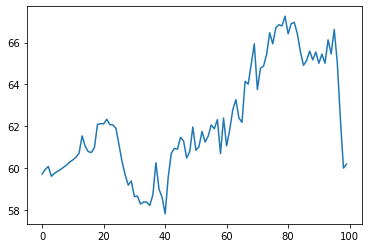

In [96]:
plt.plot(chd_vals)

In [97]:
chd.stress_period_data =  {0: chd_spd}

In [98]:
chd.check()


CHD PACKAGE DATA VALIDATION:
  No errors or warnings encountered.

  Checks that passed:
    BC indices valid
    not a number (Nan) entries
    BC in inactive cells



The code that originally imported the state soil map data was moved up above to be readily applicable to the LAK package and SFR package. gpd_mb and grid_uzf are created above

## RCH Package
1. Load in already interpolated ET and rainfall data
2. Determine where there is agricultural land to add irrigation multiplied by an efficiency factor to the rainfall array
3. Difference the rainfall and ETc arrays to dtermine how much water will recharge the aquifer
*May need to make ET and Rainfall arrays available offline on your computer*

In [104]:
ETc = np.zeros((nper-1,nrow,ncol))
rain = np.zeros((nper-1,nrow,ncol))

ETc_count = 0
for y in np.arange(pd.to_datetime(strt_date).year, pd.to_datetime(end_date).year+1):
    # set start and end date for range for the year to be iterated over
    yr_strt = pd.to_datetime(str(y)+'-01-01')
    yr_end = pd.to_datetime(str(y)+'-12-31')
    if yr_strt < pd.to_datetime(strt_date):
        yr_strt = pd.to_datetime(strt_date)
    if yr_end > pd.to_datetime(end_date):
        yr_end = pd.to_datetime(end_date)
        
    # read in text file of all of the ETc data for each year in array format    
    ET_year = np.loadtxt(gwfm_dir+'/UZF_data/ETa_all_txt_arrays/ETa_array_'+str(y)+'.tsv', delimiter = '\t')
    rain_year = np.loadtxt(gwfm_dir+'/UZF_data/Rain_all_txt_arrays/Rain_array_'+str(y)+'.tsv', delimiter = '\t')

    # get the length of the date range needed for that year
    yearlen = len(pd.date_range(yr_strt, yr_end))
    # correct the shape of the text file from 2D to 3D
    revertETc = np.reshape(ET_year, (yearlen, nrow, ncol))
    revertrain = np.reshape(rain_year, (yearlen, nrow, ncol))
    # filter the 3D array based on the desired date range
    filtered_date_ETc = revertETc[yr_strt.dayofyear-1:yr_end.dayofyear,:,:]
    filtered_date_rain = revertrain[yr_strt.dayofyear-1:yr_end.dayofyear,:,:]
    # add the data to the ETc array for the whole model time period
    ETc[ETc_count:ETc_count+yearlen,:,:] = filtered_date_ETc
    rain[ETc_count:ETc_count+yearlen,:,:] = filtered_date_rain
    ETc_count += ETc_count+yearlen

In [105]:

# logical array where 1 represents ag land and 0 represents non ag land as listed above
ag_land_arr = np.loadtxt(gwfm_dir+'/UZF_data/array_of_agriculture_land.tsv')
# create a bool array of the oppostite of ag land
non_ag_land_arr = ~ag_land_arr.astype(bool)

In [106]:
# wherever there is ag land and not enough rain to meet the ETc then it will be met by applying 1.05*ETc
# to the .FINF array
# start by setting the rain of non_ag_land to np.nan to be ignored in calculations
ag_rch = np.copy(rain)
ag_rch[:,non_ag_land_arr] = np.nan
# whereever the rain is less than ETc for ag land set the recharge equal to the etc times 0.05 for irrigation inefficiency
# could calibrate this irrigation efficiency later
ag_rch[ag_rch<ETc] = ETc[ag_rch<ETc]*0.05
# return np.nan values to zeros
ag_rch[np.isnan(ag_rch)] = 0

In [107]:
# final calculation for RCH package

net_inf = rain + ag_rch - ETc
# assuming there is irrigation to make up lack of rainfall
# net_inf should never be less than zero
np.mean(net_inf, axis = (1,2))

net_inf = np.where(net_inf<0, 0, net_inf)


In [108]:
# add an empty array for the first blank stress period
# net_inf = np.vstack((np.zeros((1,nrow,ncol)),net_inf))

In [109]:
# have transient recharge start after the 1st spd
rech_spd = { (j): net_inf[j-1,:,:] for j in np.arange(1,nper)}

In [110]:
# nrchop = 3, to highest active cell
rch =flopy.modflow.ModflowRch(model = m, nrchop=3, rech = rech_spd)

## Well Package


In [111]:
wells = pd.read_csv(gwfm_dir+'/WEL_data/all_wells_type.csv')
wells_grid = gpd.GeoDataFrame(wells, geometry = gpd.points_from_xy(wells.easting,wells.northing), crs = 'epsg:32610')

In [112]:
wells_grid_ag = wells_grid[:]
wells_grid_ag = wells_grid.loc[wells_grid.Simple_type == 'irrigation'].dissolve('node', aggfunc = 'mean')
wells_grid_ag.geometry = wells_grid.loc[wells_grid.Simple_type == 'irrigation'].dissolve('node', aggfunc = 'first').geometry

C:\Users\andrewc\Anaconda3\envs\geosp\lib\site-packages\geopandas\geoseries.py:207: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  s = pd.Series(data, index=index, name=name, **kwargs)
C:\Users\andrewc\Anaconda3\envs\geosp\lib\site-packages\geopandas\geoseries.py:207: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  s = pd.Series(data, index=index, name=name, **kwargs)
C:\Users\andrewc\Anaconda3\envs\geosp\lib\site-packages\geopandas\geoseries.py:207: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  s = pd.Series(data, index=index, name=name, **kwargs)
C:\Users\andrewc\Anaconda3\envs\geosp\lib\site-packages\geopandas\geoseries.py:207

C:\Users\andrewc\Anaconda3\envs\geosp\lib\site-packages\geopandas\geoseries.py:207: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  s = pd.Series(data, index=index, name=name, **kwargs)
C:\Users\andrewc\Anaconda3\envs\geosp\lib\site-packages\geopandas\geoseries.py:207: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  s = pd.Series(data, index=index, name=name, **kwargs)
C:\Users\andrewc\Anaconda3\envs\geosp\lib\site-packages\geopandas\geoseries.py:207: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  s = pd.Series(data, index=index, name=name, **kwargs)
C:\Users\andrewc\Anaconda3\envs\geosp\lib\site-packages\geopandas\geoseries.py:207

In [113]:
wells_grid['depth_m'] = wells_grid.TotalCompletedDepth*0.3048


In [114]:
wells_grid['flux'] = 0
wells_grid['layer'] = 0

In [115]:
num_ag = (wells_grid.Simple_type == 'irrigation').sum()
ET_ag = ETc*ag_land_arr
ET_ag_monthly_sum = ET_ag.sum(axis=(1,2))
# calculate ag well flux by average ET
aggregated_irrig_flux = ET_ag_monthly_sum/num_ag


In [116]:
# assume each public supply well serves 5-10,000 people each needing 50 gpd, then need to convert to ft^3
public_flux = (5000*50/7.48)*(0.3048**3)
# public_flux = 1500*(1/7.48)*(0.3048**3)*60*24

# averge pumping rate of domestic wells is 10-100 gpm, typically on the lower end and 
# should end up being around 50 gal/person a day and average 3 people is 150 gal/day
# 10 gpm * (1 ft^3/ 7.48 gal) (ft^3/m^3)*60 min hour* 3 hours in a day * 30 days

dom_flux = 30*(1/7.48)*(0.3048**3)*60*24
print('Irrig flux:', '%.3e' % (aggregated_irrig_flux.mean()*270*270), 'Public flux:', '%.3e' %public_flux,'Domestic flux:', '%.3e' %dom_flux)

Irrig flux: 2.441e+03 Public flux: 9.464e+02 Domestic flux: 1.635e+02


In [117]:
# define pumping rate based on well use, average pumping rate in m^3/day
# wells_grid.loc[wells_grid.Simple_type == 'irrigation', 'flux'] = -irrig_flux
wells_grid.loc[wells_grid.Simple_type == 'domestic', 'flux'] = -dom_flux
wells_grid.loc[wells_grid.Simple_type == 'public', 'flux'] = -public_flux

In [118]:
if wells_grid.row.min()==1:
    wells_grid.row = (wells_grid.row-1).astype(int)
    wells_grid.column = (wells_grid.column -1).astype(int)

In [119]:
mean_ag_well_depth = wells_grid.loc[wells_grid.Simple_type == 'irrigation'].TotalCompletedDepth.mean()*0.3048
mean_ag_well_depth

107.05973

In [120]:

for k in np.arange(0,nlay-1):
    # pull out elevation of layer bottom
    lay_elev = botm[k, :, :]
    for i in np.arange(0,len(wells_grid)):
        # want to compare if streambed is lower than the layer bottom
        # 1 will be subtracted from each z value to make sure it is lower than the model top in the upper reaches
        if lay_elev[wells_grid.row.values[i],wells_grid.column.values[i]] > dem_data[wells_grid.row.values[i],wells_grid.column.values[i]]-wells_grid.depth_m.iloc[i]:
            wells_grid.layer.iloc[i] = k     

C:\Users\andrewc\Anaconda3\envs\geosp\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [121]:
print('Cells with wells: ', wells_grid.dissolve(by='node',aggfunc='first').shape[0], 'total wells: ', wells_grid.shape[0])
print('Wells with TRS accuracy: ', (wells_grid.MethodofDeterminationLL == 'Derived from TRS').sum())

wells_grid_notrs = wells_grid.loc[wells_grid.MethodofDeterminationLL != 'Derived from TRS']

C:\Users\andrewc\Anaconda3\envs\geosp\lib\site-packages\geopandas\geoseries.py:207: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  s = pd.Series(data, index=index, name=name, **kwargs)
C:\Users\andrewc\Anaconda3\envs\geosp\lib\site-packages\geopandas\geoseries.py:207: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  s = pd.Series(data, index=index, name=name, **kwargs)
C:\Users\andrewc\Anaconda3\envs\geosp\lib\site-packages\geopandas\geoseries.py:207: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  s = pd.Series(data, index=index, name=name, **kwargs)
C:\Users\andrewc\Anaconda3\envs\geosp\lib\site-packages\geopandas\geoseries.py:207

C:\Users\andrewc\Anaconda3\envs\geosp\lib\site-packages\geopandas\geoseries.py:207: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  s = pd.Series(data, index=index, name=name, **kwargs)
C:\Users\andrewc\Anaconda3\envs\geosp\lib\site-packages\geopandas\geoseries.py:207: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  s = pd.Series(data, index=index, name=name, **kwargs)
C:\Users\andrewc\Anaconda3\envs\geosp\lib\site-packages\geopandas\geoseries.py:207: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  s = pd.Series(data, index=index, name=name, **kwargs)
C:\Users\andrewc\Anaconda3\envs\geosp\lib\site-packages\geopandas\geoseries.py:207

C:\Users\andrewc\Anaconda3\envs\geosp\lib\site-packages\geopandas\geoseries.py:207: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  s = pd.Series(data, index=index, name=name, **kwargs)
C:\Users\andrewc\Anaconda3\envs\geosp\lib\site-packages\geopandas\geoseries.py:207: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  s = pd.Series(data, index=index, name=name, **kwargs)
C:\Users\andrewc\Anaconda3\envs\geosp\lib\site-packages\geopandas\geoseries.py:207: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  s = pd.Series(data, index=index, name=name, **kwargs)
C:\Users\andrewc\Anaconda3\envs\geosp\lib\site-packages\geopandas\geoseries.py:207

Cells with wells:  1380 total wells:  2482
Wells with TRS accuracy:  823


C:\Users\andrewc\Anaconda3\envs\geosp\lib\site-packages\geopandas\geoseries.py:207: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  s = pd.Series(data, index=index, name=name, **kwargs)
C:\Users\andrewc\Anaconda3\envs\geosp\lib\site-packages\geopandas\geoseries.py:207: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  s = pd.Series(data, index=index, name=name, **kwargs)
C:\Users\andrewc\Anaconda3\envs\geosp\lib\site-packages\geopandas\geoseries.py:207: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  s = pd.Series(data, index=index, name=name, **kwargs)
C:\Users\andrewc\Anaconda3\envs\geosp\lib\site-packages\geopandas\geoseries.py:207

In [122]:
# wells_grid_notrs['count_per_cell'] = 1
# # all_wells_grid['MFCell'] = all_wells_grid.Township+all_wells_grid.Range+all_wells_grid.k.astype(str)
# wells_grid_sum = wells_grid_notrs.dissolve(by = 'node', aggfunc='sum')
# wells_grid_sum.plot('count_per_cell',legend=True)
# print(wells_grid_sum.count_per_cell.median(), wells_grid_sum.count_per_cell.mean(), wells_grid_sum.count_per_cell.max())


In [123]:
# save domestic, public wells for their pumping doesn't depend on ET
wells_grid_no_ag = wells_grid.loc[wells_grid.Simple_type != 'irrigation']
# filter out data for wel package
spd_noag = wells_grid_no_ag.loc[:,['layer','row','column', 'flux']].values


#### Using ETc in all cells for pumping


In [124]:
# layer for ETc ag well pumping
ETc_lay = 1
# create empty dictionary to fill with stress period data
wel_ETc_dict = {}
# end date is not included as a stress period, starting at 1st TR spd (2)
for t in np.arange(1,nper):
    wel_i, wel_j = np.where(ET_ag[t-1,:,:]>0)
    wel_ETc = -ET_ag[t-1,wel_i,wel_j]*delr*delr
    # ['layer','row','column', 'flux'] are necessary for WEL package
    spd_ag = np.stack((ETc_lay*np.ones(len(wel_i)), wel_i, wel_j,wel_ETc),axis=1)
    spd_all = np.vstack((spd_ag,spd_noag)) # join pumping from ag with point pumping from domstic/supply wells that are constant
    wel_ETc_dict[t] = spd_all

In [125]:
ET_ag_ss = ET_ag.mean(axis=(0))
wel_i, wel_j = np.where(ET_ag_ss[:,:]>0)
wel_ETc = -ET_ag_ss[wel_i,wel_j]*delr*delr
# ['layer','row','column', 'flux'] are necessary for WEL package
# add average ag well pumping as steady state period
wel_ETc_dict[0] = np.stack((ETc_lay*np.ones(len(wel_i)), wel_i, wel_j,wel_ETc),axis=1)

In [126]:
# Create well flopy object
wel = flopy.modflow.ModflowWel(m, stress_period_data=wel_ETc_dict,ipakcb=55)

## Output Control

In [127]:
# Output control
# default unit number for heads is 51, cell by cell is 53 and drawdown is 52
# (0,0) is (stress period, time step)

# For later model runs when all the data is needed to be saved
spd = { (j,0): ['save head', 'save budget'] for j in np.arange(0,nper,1)}

# get the first of each month to print the budget
month_intervals = (pd.date_range(strt_date,end_date, freq="MS")-pd.to_datetime(strt_date)).days

for j in month_intervals:
    spd[j,0] = ['save head', 'save budget','print budget']
    
oc = flopy.modflow.ModflowOc(model = m, stress_period_data = spd, compact = True)

## Newton Solver

In [128]:
# pcg = flopy.modflow.ModflowPcg(model = m)
# nwt = flopy.modflow.ModflowNwt(model= m)
# thickfact: portion of cell thickness used for smoothly adjusting storage and conductance coefficients to zero (default is 1e-5)
# linmeth (linear method): 1 for GMRES and 2 for XMD (1 is default)
# iprnwt: flag whether additional info about solver convergence will be printed to the main listing file (default is 0)
# ibotav: flag whether corretion will be made to gw head relative to cell-bottom if surrounded by dry cells.
# 1 = corrections and  0 = no correction (default is 0)
# options: specify comlexity of solver. SIMPLE : default solver for linear models, MODERATE for moderately nonlinear models,
# COMPLEX for highly nonlinear models (default is COMPLEX)
# Continue: if model fails to converge during a time step it will continue to solve the next time step (default is False) 
# epsrn (XMD) is the drop tolerance for preconditioning (default is 1E-4)
# hclosexmd (XMD) head closure criteria for inner (linear) iterations (default 1e-4)

# nwt = flopy.modflow.ModflowNwt(model = m, headtol=0.01, fluxtol=500, maxiterout=200, thickfact=1e-05, 
#                                linmeth=1, iprnwt=1, ibotav=0, options='COMPLEX', Continue=False,
#                                maxbackiter=50, backtol=1.1, maxitinner=50, ilumethod=2, 
#                                levfill=5, stoptol=1e-10, msdr=15, iacl=2, norder=1, level=5, north=7, 
#                                iredsys=0, rrctols=0.0, idroptol=1, epsrn=0.0001, hclosexmd=0.0001, 
#                                mxiterxmd=50, extension='nwt', unitnumber=None, filenames=None)



# GMG is more successful than pcg which is fine for steady state model
# mxiter, max outer, iiter = max inner, hclose = head change criterion for convergence, 
# rclose = residual criterion for convergence

# gmg = flopy.modflow.ModflowGmg(model = m, mxiter=50, iiter=30, hclose = 1e-5, rclose = 1e-5)

In [129]:
# iter_mo max outer iters, ter_mi = max inner iters, close_r residual criterion for stopping iteration
# close_h is alternate criterion for nonlinear problem, and is head closure which should be smaller than residual closer
# ipunit =0 means no info on solver, ipunit=1 means output about solver issues is written
# if iter_mo >1 then closer_r is used not close_h and closer_r is compared to 
# the square root of the inner product of the residuals (the residual norm)
# adamp =0 is std damping, adamp=1 is adaptive damping that further decreases or increases damping based on picard
# iteration sucess
#adamp is 0.7 to resolve issues with heads oscillating near solution +1 m
# damp_lb = lower bound, rate_d is rate of increase of damping based picard iteration success
pcgn = flopy.modflow.ModflowPcgn(m, iter_mo = 100, iter_mi=60, close_r=1e-01, close_h=1e-02, ipunit=28)
#                                adamp=1, damp=0.7, damp_lb=0.1, rate_d=0.01)

In [130]:
m.get_package_list()
# m.remove_package('DATA')
# m.remove_package('RIV')
# m.remove_package('WEL')
# m.remove_package('RCH')


['DIS', 'RIV', 'BAS6', 'GHB', 'LPF', 'CHD', 'RCH', 'WEL', 'OC', 'PCGN']

In [131]:

m.check()
# lak.check()
# upw.check()


MF MODEL DATA VALIDATION SUMMARY:
  2737001 Errors:
    DIS package: thin cells (less than checker threshold of 1.0)
    No solver package
  1 Warning:
    RCH package: Mean R/T ratio < checker warning threshold of 2e-08 for 582 stress periods

  Checks that passed:
    Unit number conflicts
    DIS package: zero or negative thickness
    DIS package: nan values in top array
    DIS package: nan values in bottom array
    RIV package: stage below cell bottom
    RIV package: rbot below cell bottom
    RIV package: RIV stage below rbots
    BAS6 package: isolated cells in ibound array
    BAS6 package: Not a number
    GHB package: BC indices valid
    GHB package: not a number (Nan) entries
    GHB package: BC in inactive cells
    GHB package: BC elevation below cell bottom
    LPF package: zero or negative horizontal hydraulic conductivity values
    LPF package: zero or negative vertical hydraulic conductivity values
    LPF package: negative horizontal anisotropy values
    LPF pa

## Write the input files

In [ ]:
# Writing the MODFLOW data files
m.write_input()


# Run the model

In [249]:
# success, buff = m.run_model()

FloPy is using the following  executable to run the model: C:\WRDAPP\MODFLOW-NWT_1.2.0\bin\MODFLOW-NWT.exe

                                  MODFLOW-NWT-SWR1 
    U.S. GEOLOGICAL SURVEY MODULAR FINITE-DIFFERENCE GROUNDWATER-FLOW MODEL
                             WITH NEWTON FORMULATION
                             Version 1.2.0 03/01/2020                        
                    BASED ON MODFLOW-2005 Version 1.12.0 02/03/2017                       

                    SWR1 Version 1.04.0 09/15/2016                       

 Using NAME file: MF.nam 
 Run start date and time (yyyy/mm/dd hh:mm:ss): 2021/05/10 11:51:09

forrtl: severe (41): insufficient virtual memory
Image              PC        Routine            Line        Source             
MODFLOW-NWT.exe    00FC3B99  Unknown               Unknown  Unknown
MODFLOW-NWT.exe    00C28F16  Unknown               Unknown  Unknown
MODFLOW-NWT.exe    00EC4D2F  Unknown               Unknown  Unknown
MODFLOW-NWT.exe    00EB99F2  Unknown  

 insufficient virtual memory means there is way too much data for the fortran arrays too hold, more than the 16 gb I have available